2.	**How to run your code (what command-line switches they are, what happens when you invoke the code, etc.)**

    The pre-requisites are detailed in README.txt. Please install all the packages to ensure the following operations.
    
    1. The jupyter notebook file (Michi_Wang_Final_Project.ipynb) shows clearly the steps of the data cleaning, analysis, and conclusion. 
    
    2. For the usage python file (Michi_Wang_Final_Project.py), there are two ways to run from the command line:
        1. `python Michi_Wang_Final_Project.py --static`\
        This opens the stored database and performs analysis on stored data
        2. `python Michi_Wang_Final_Project.py`\
        scrape the complete data, store in a database, then perform analysis on the database (most recently scraped data)

3.	**Any major “gotchas” to the code (i.e. things that don’t work, go slowly, could be improved, etc.)**

    There are two possible issues:
    1. After several times of scraping from the website (https://cryptoslam.io/), it starts to reject my access (403 forbidden). It is probably becuause of the website mod_security or some similar server security feature which blocks known spider/bot user agents. There are two potential solutions
        1. Set a known browser user agent. \
        ```
        from urllib.request import Request, urlopen

        req = Request('https://cryptoslam.io/', headers={'User-Agent': 'Mozilla/5.0'})
        webpage = urlopen(req).read()
        ```
        2. Use a different source of data.\
        e.g. https://opensea.io/rankings or https://ranknft.io/
    
    2. When scraping the whole dataset, it will print error message like "JSON Query to explore/tags/mnlthskin/: 404 Not Found [retrying; skip with ^C]" in the terminal. It is because the API is not able to find the exact content. This can be ignored and wail until it complete scraping. 



4.  **Anything else you feel is relevant to the grading of your project your project.**

    As I mentioned above, after several times of scraping from the website (https://cryptoslam.io/), it starts to reject my access (403 forbidden). It is probably becuause of the website mod_security or some similar server security feature which blocks known spider/bot user agents.

5. **What did you set out to study?  (i.e. what was the point of your project?  This should be close to your Milestone 1 assignment, but if you switched gears or changed things, note it here.)**

    The NFT market is at the rage of the prevalence of decentralized blockchains. A couple of digital arts were once caused a sensation with their sky-high sale price. At the same time, it raises the question that do they reflecting the real price. The purpose of this project is to check how the influence of Instagram and the news will affect the trading activity of NFTs. The hypothesis was the trading activities of the NFT market are highly dependent on the influence of influencers and news. The number of times an NFT project is mentioned on Instagram and on the news website in a week will be reflected in the weekly trading volume change.
    
    With the progressive of the project, there are minor changes. I changed the source of the data. The three sources were twitter, cryptoslam, and nonfungible news. The twitter was replaced by instagram posts, since twitter has a strict restrictions of their APIs, and instagram API is more flexible. Also, the nonfungible news was replaced by google news, which gives us more conprehensive data. 

6. **What did you Discover/what were your conclusions (i.e. what were your findings?  Were your original assumptions confirmed, etc.?)**

    The hypothesis was the trading activities of the NFT market are highly dependent on the influence of influencers and news. The number of times an NFT project is mentioned on Instagram and on the news website in a week will be reflected in the weekly trading volume change.
    
    The assumption of the three sets of data is close to:\
    Y = m1*X_news + m2*X_ig + b\
    Where m1 and m2 are positive real numbers;\
    X_new is the number of times an NFT project is mentioned in the news within seven days;\
    X_ig is the number of times an NFT project is tagged in a post within seven days;\
    And Y is the transaction number of an NFT project within seven days.
    
    Through the analysis, m2, which is the coefficient of instagram posts, turned out has no obvious statistical signifiacance of the observed difference in the data, so is set to zero. And the linearity between m1 and Y is proven. 
    
    The approximate relationship is \
    transaction # = 13.6616 * news # + 0 * instagram posts # + 119.3625\
    Y = 13.6616 * X_news + 0 * X_ig + 119.3625

7. **What difficulties did you have in completing the project?**  

    Data cleaning was the most difficult part of the project. When downloading the data, the scraped data had a lot of messy codes, repetition, etc. 
    
    What is more, finding a good source of data was also difficult. Although there might be a good assumption, it still required me to find an appropriate source to operate on. 

8. **What skills did you wish you had while you were doing the project?**

    Data cleaning, data visualization, data analysis, and model fitting. The data cleaning took me most of the time. Also, what kind of analysis to use was crutial as well. 

9. **What would you do “next” to expand or augment the project?**

    For now there is only the data within seven days. The next step would be epanding the time period to probably a month, to see if the news and instagram posts has a longer term of effect on the respective nft project transactions. 
    
    Or, using more sources of data to see if different kinds of social media can weight different on the efficacy of the promotion of NFT projects. 

In [167]:
import pandas as pd
import numpy as np
import requests
import re
from pygooglenews import GoogleNews
import instaloader
from datetime import datetime, timedelta
import warnings
from itertools import dropwhile, takewhile
import time
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import sys
import statsmodels.api as sm


warnings.filterwarnings("ignore")

In [168]:
# function used to delete the duplicate string
def delete_duplicate(s:str)->str:
    return s[:int(len(s)/2)]

In [169]:
def count_ig_posts(name:str)->int:
    try:
        L = instaloader.Instaloader()
        name = name.replace(' ', '')
        posts = instaloader.Hashtag.from_name(L.context, name).get_posts()
        end = datetime.today()
        start = end - timedelta(days=7)
        k = 0
        for post in takewhile(lambda p: p.date > start, dropwhile(lambda p: p.date > end, posts)):
            k += 1
            if k == 500:
                break
        return k
    except:
        return 0


In [170]:
# scrape and clean the transaction data
# return a dataframe
def scrape_nft_transactions(): 
    # get the NFT salse information
    response = requests.get('https://cryptoslam.io/')
    content = response.text.split('\n')
    for pos in range(len(content)):
        if len(re.findall('class=\"caret\"', content[pos])) and len(re.findall('\%', content[pos])):
            m = re.search(';(\d+).(\d+)\%',content[pos])
            updated = f';-{m.group(1)}.{m.group(2)}%'
            new = re.sub(m.group(0), updated, content[pos])
            content[pos] = new
    content = '\n'.join(content)
    df = pd.read_html(str(content))[0]
    df['Collection'] = df['Collection'].map(delete_duplicate)
    df.drop(df.columns[[0,2]],axis=1, inplace=True)
    return df

In [171]:
# scrape the news
# return added dataframe
def scrape_news(df):
    news_number = []
    gn = GoogleNews()
    for i in list(df['Collection']):
        search = gn.search(i, when = '7d')
        n = len(search['entries'])
        news_number.append(n)

    # add to the main df
    tmp = pd.DataFrame(news_number,columns=['Number of News'])
    data = pd.concat([df,tmp],axis=1)
    return data


In [172]:
# scrape the instagram
# return added dataframe
def scrape_instagram(data):
    ig_number = []
    totol = 0
    for i in list(data['Collection']):
        k = count_ig_posts(i)
        ig_number.append(k)
        totol += k
        if totol > 2500:
            time.sleep(60)
            totol = 0

    # add to the main df
    tmp = pd.DataFrame(ig_number,columns=['Number of Instagram Posts'])
    data = pd.concat([data,tmp],axis=1)
    return data

In [173]:
# store the df into a csv
def df2csv(data, path='data.csv'):
    data.to_csv(path)
    return

In [174]:
# normalize the inputs into the same scale
def normalize(data):
    X = data[['Number of News', 'Number of Instagram Posts']].values
    scaler = preprocessing.MinMaxScaler()
    normalized = scaler.fit_transform(X)
    normalized_df = pd.DataFrame(normalized)
    return normalized_df

In [175]:
# plot and save the diagram to show how the three data sources join
# 1. NFT collections transactions
# 2. News mentioning the NFT collection
# 3. Instagram posts taggging the NFT collection
def plot_save_diagram(normalized_df, data):
    plt.scatter(normalized_df[0], data['Txns'], c='y', label='News')
    plt.scatter(normalized_df[1], data['Txns'], c='g', label='Instagram')
    plt.legend()
    plt.title('Normalized Source Data v.s. NFT Collection Transactions in 7 Days')
    plt.savefig('diagram.png')
    return

In [176]:
# Descriptive statistics include those that summarize the central tendency,
# dispersion and shape of a dataset’s distribution
def printStatistics(data)->None:
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    print('-------- Data Statistics --------')
    print(data.describe())
    return

In [177]:
# plot the linear regression 
def plotLR(x1, x2, y):
    plt.scatter(x1, y, c='y', label='News')
    plt.scatter(x2, y, c='g', label='Instagram')
    m1,b1 = np.polyfit(x1, y, 1)
    m2,b2 = np.polyfit(x2, y, 1)
    plt.plot(x1, m1*x1+b1, c='y')
    plt.plot(x2, m2*x2+b2, c='g')
    plt.legend()
    plt.title('Fitted Linear Regression')
    plt.savefig('LR.png')
    return

In [178]:
# create a model using sm.OLS
def fitOLS(X, Y):
    model = sm.OLS(Y, X, hasconst=True).fit()
    print(model.summary())
    return

In [179]:
# calculate the relationship manually
def calculateRelationship(x_mean, y_mean, n, X_news, Y_news):
    Sxy = np.sum(X_news*Y_news)- n*x_mean*y_mean
    Sxx = np.sum(X_news*X_news)-n*x_mean*x_mean

    m = Sxy/Sxx
    b = y_mean-m*x_mean
    print('----------- relationship -----------')
    print('The relationship between x (number of news) and y (number of nft transactions) is')
    print(f'y = {m} * x + {b}')

In [180]:
# plot and save the histogram of the data
def plotHist(X):
    plt.hist(data[X], 20)  
    plt.title('Histogram of '+X)
    plt.savefig('Hist_'+X+'.png')
    return

In [181]:
data = pd.read_csv('data.csv', index_col=0)
print('-------- Static Data --------')
print(data)
printStatistics(data)

-------- Static Data --------
                Collection        Sales Change (24h)  Buyers  Txns  \
0    Mutant Ape Yacht Club  $22,875,948       55.58%     176   203   
1     Bored Ape Yacht Club  $16,744,075       94.28%      37    46   
2                Moonbirds   $6,882,908      -73.79%      66    67   
3    Bored Ape Kennel Club   $5,064,112       -1.41%     113   141   
4              RTFKT MNLTH   $4,039,945      -40.85%      72   121   
..                     ...          ...          ...     ...   ...   
245          JRNY NFT Club      $17,940      -69.86%       6     6   
246           Alien Worlds      $17,443      -20.65%     609  3792   
247                Flappyz      $17,228      468.30%      23    47   
248             MiningLabs      $17,176       37.59%      42    47   
249            hic et nunc      $16,985       22.22%     714  1785   

     Number of News  Number of Instagram Posts  
0                26                        346  
1               100            

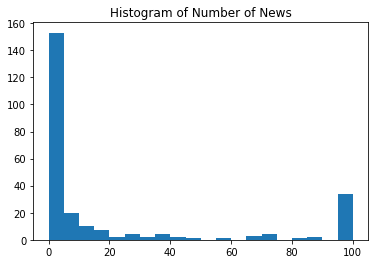

In [182]:
plotHist('Number of News')

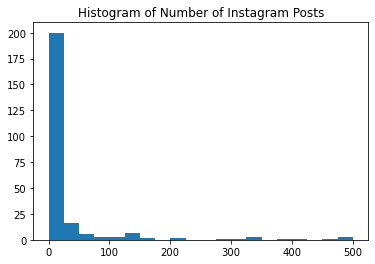

In [183]:
plotHist('Number of Instagram Posts')

From the histograms above, we can see that there are many zeros in the data. Both of them have a great amount of zeros. Neither of the data is indicating a typical kind of distribution. 

diagram.png created successfully


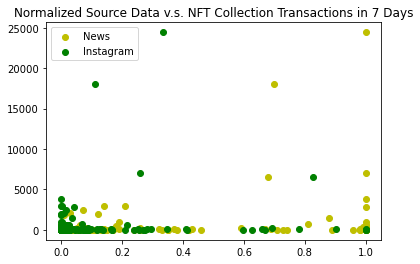

In [184]:
# find the relationship between 2 inputs and the output
normalized = normalize(data)
plot_save_diagram(normalized, data)
print('diagram.png created successfully')
normalized = normalized.rename(columns={0:'Number of News', 1:'Number of Instagram Posts'})


LR.png created successfully


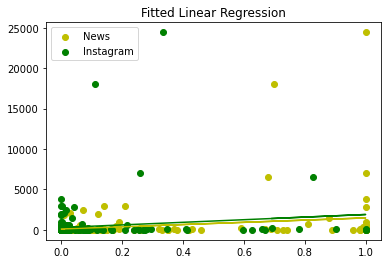

In [185]:
# plot LR of both inputs to see if we can tell directly the relationships
x1 = normalized.iloc[:, 0]
x2 = normalized.iloc[:, 1]
y = data['Txns']
plotLR(x1, x2, y)
print('LR.png created successfully')

From the above plot, it is hard for us to infer directly that there are linear relationships between the number of news, number of instagram posts, and number of transactions.

In [186]:
# find the relationship between the inputs and the output
X = normalized
Y = data['Txns']
fitOLS(X, Y)

                            OLS Regression Results                            
Dep. Variable:                   Txns   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     15.89
Date:                Tue, 10 May 2022   Prob (F-statistic):           8.85e-05
Time:                        23:10:53   Log-Likelihood:                -2251.9
No. Observations:                 250   AIC:                             4508.
Df Residuals:                     248   BIC:                             4515.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Number of News        

From the above summary of the regression we fit from the data, the p value of "Number of News" is less than 0.05, we can reject the null hypothesis (there's no relationship between the number of news and the number of transctions), so there should be a relationship between it and the number of transactions; on the other hand, the p value of "Number of Instagram Posts" is greatter than 0.05, so we can infer it has no obvious statistical signifiacance of the observed difference in the data.

Therefore, we can say the second input has no obvious effect towards our output. There's no need to use the normalizd data anymore. So, we can used the original data to findout the relationship between number of news and number of transactions.

In [187]:
# fit a model on only on the number of news as input
X_news = pd.concat([data['Number of News'], pd.DataFrame([1]*250)], axis=1)
Y_news = data['Txns']
fitOLS(X_news, Y_news)

                            OLS Regression Results                            
Dep. Variable:                   Txns   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     14.74
Date:                Tue, 10 May 2022   Prob (F-statistic):           0.000156
Time:                        23:10:53   Log-Likelihood:                -2252.4
No. Observations:                 250   AIC:                             4509.
Df Residuals:                     248   BIC:                             4516.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Number of News    13.6616      3.558      3.

From the above summary, the calculated relationship is y = 13.6616 * x + 119.3625.

The R squared is pretty low. Then we can manually calculate the relationship mx+b between number of news and number of transactions.

In [188]:
# manual calculation 
x_mean = np.mean(data['Number of News'])
y_mean = np.mean(data['Txns'])
n = 250
calculateRelationship(x_mean, y_mean, n, data['Number of News'], Y_news)

----------- relationship -----------
The relationship between x (number of news) and y (number of nft transactions) is
y = 13.661646384075631 * x + 119.36250619177963


The manual calculation agrees with the model calculation. So, we can conclude the relationship between the three variables within 7 days:

transaction # = 13.6616 * news # + 0 * instagram posts # + 119.3625